# Dubins path algorithm

- Reference 
    - https://github.com/dawnjeanh/motionplanning/blob/master/python/dubins_path.py
    - https://en.wikipedia.org/wiki/Dubins_path

In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import time
from copy import deepcopy

- Initialize variable

In [159]:
delta_max = 40 # max steering angle [deg]
L = 4 # wheel base [m]
r_turn = L / np.tan(delta_max * np.pi/180)
print("MAX STEER ANGLE : {} [deg], TURNING RADIUS : {:.2f} [m] ".format(delta_max, r_turn))
ds = 0.5

X_EXPAND = 40 # [m]

MAX STEER ANGLE : 40 [deg], TURNING RADIUS : 4.77 [m] 


## Dubins path

In [163]:
class DubinsPath():
    def __init__(self, init_state, goal_state, r_turn):
        self.qi = init_state
        self.qg = goal_state
        self.r = r_turn
        self.path = []
                      
        self.dubins_words = [self.dubins_LSL,
                                    self.dubins_LSR,
                                    self.dubins_RSL,
                                    self.dubins_RSR,
                                    self.dubins_LRL,
                                    self.dubins_RLR]
    
    def mod2pi(self, theta):
        return theta - 2*np.pi * np.floor(theta / (2*np.pi))
        
    
    def set_dubins_path(self, step_size):
        di = self.dubins_init()
        for w in self.dubins_words:
            path = w(di, step_size)
            if path is not None:
                self.path.append(path)
    
    
    def get_shortest_path(self):
        shortest_cost = float("inf")
        shortest_path = []
        for path in self.path:
            if path:
                cost = 0
                for p in path:
                    if p[0] == 's':
                        cost += p[1]
                    else:
                        cost += p[1] * self.r 
                if cost < shortest_cost:
                    shortest_path = path
                    shortest_cost = cost
        return deepcopy(shortest_path), shortest_cost  
    
    
    def dubins_init(self):
        dx = self.qg[0] - self.qi[0]
        dy = self.qg[1] - self.qi[1]
        dyaw = self.qg[2] - self.qi[2]
        
        dx_ = dx * np.cos(self.qi[2]) + dy * np.sin(self.qi[2])
        dy_ = -dx * np.sin(self.qi[2]) + dy * np.cos(self.qi[2])
        dx_ = dx_ / self.r
        dy_ = dy_ / self.r

        return [dx_, dy_, dyaw]

    
    def dubins_LSL(self, di, step_size):
        u_ct = di[0] - np.sin(di[2])
        u_st = di[1] - 1 + np.cos(di[2])

        u = np.sqrt(u_ct**2 + u_st**2)
        t = self.mod2pi(np.arctan2(u_st, u_ct))
        v = self.mod2pi(di[2] - t)

        if step_size <= t*self.r:
            return [['l', step_size/self.r]]
        elif step_size > t*self.r and step_size <= t*self.r + u*self.r:
            return [['l', t], ['s', step_size-t*self.r]]
        elif step_size > t*self.r + u*self.r and step_size <= t*self.r + u*self.r + v*self.r:
            return [['l', t], ['s', u * self.r], ['l', step_size/self.r-t-u]]
        else:        
            return [['l', t], ['s', u * self.r], ['l', v]]

    
    def dubins_LSR(self, di, step_size):
        u1_ct1 = di[0] + np.sin(di[2])
        u1_st1 = di[1] - 1 - np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 < 2:
            return []
        else:
            u = np.sqrt(u1**2 - 4)
            theta = np.arctan2(2, u)
            t1 = np.arctan2(u1_st1, u1_ct1)
            t = self.mod2pi(t1 + theta)
            v = self.mod2pi(t - di[2])

            if step_size <= t*self.r:
                return [['l', step_size/self.r]]
            elif step_size > t*self.r and step_size <= t*self.r + u*self.r:
                return [['l', t], ['s', step_size-t*self.r]]
            elif step_size > t*self.r + u*self.r and step_size <= t*self.r + u*self.r + v*self.r:
                return [['l', t], ['s', u * self.r], ['r', step_size/self.r-t-u]]
            else:        
                return [['l', t], ['s', u * self.r], ['r', v]]

        
    def dubins_RSL(self, di, step_size):
        u1_ct1 = di[0] - np.sin(di[2])
        u1_st1 = -di[1] - 1 - np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 < 2:
            return []
        else:
            u = np.sqrt(u1**2 - 4)
            theta = np.arctan2(2, u)
            t1 = np.arctan2(u1_st1, u1_ct1)
            t = self.mod2pi(t1 + theta)
            v = self.mod2pi(t + di[2])
            
            if step_size <= t*self.r:
                return [['r', step_size/self.r]]
            elif step_size > t*self.r and step_size <= t*self.r + u*self.r:
                return [['r', t], ['s', step_size-t*self.r]]
            elif step_size > t*self.r + u*self.r and step_size <= t*self.r + u*self.r + v*self.r:
                return [['r', t], ['s', u * self.r], ['l', step_size/self.r-t-u]]
            else:        
                return [['r', t], ['s', u * self.r], ['l', v]]
        
        
    def dubins_RSR(self, di, step_size):
        u_ct = di[0] + np.sin(di[2])
        u_st = -di[1] - 1 + np.cos(di[2])

        u = np.sqrt(u_ct**2 + u_st**2)
        t = self.mod2pi(np.arctan2(u_st, u_ct))
        v = self.mod2pi(-di[2] - t)
        
        if step_size <= t*self.r:
            return [['r', step_size/self.r]]
        elif step_size > t*self.r and step_size <= t*self.r + u*self.r:
            return [['r', t], ['s', step_size-t*self.r]]
        elif step_size > t*self.r + u*self.r and step_size <= t*self.r + u*self.r + v*self.r:
            return [['r', t], ['s', u * self.r], ['r', step_size/self.r-t-u]]
        else:        
            return [['r', t], ['s', u * self.r], ['r', v]]
  

    def dubins_LRL(self, di, step_size):
        u1_ct1 = di[0] - np.sin(di[2])
        u1_st1 = di[1] - 1 + np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 > 4:
            return []
        else:
            t1 = np.arctan2(u1_st1, u1_ct1)
            theta = np.arccos(u1/4)
            t = self.mod2pi(np.pi/2 + t1 + theta)
            u = self.mod2pi(np.pi + 2*theta)
            v = self.mod2pi(np.pi/2 + theta + di[2] - t1)
            
            if step_size <= t*self.r:
                return [['l', step_size/self.r]]
            elif step_size > t*self.r and step_size <= t*self.r + u*self.r:
                return [['l', t], ['r', step_size/self.r-t]]
            elif step_size > t*self.r + u*self.r and step_size <= t*self.r + u*self.r + v*self.r:
                return [['l', t], ['r', u], ['l', step_size/self.r-t-u]]
            else:        
                return [['l', t], ['r', u], ['l', v]]

            
    def dubins_RLR(self, di, step_size):
        u1_ct1 = di[0] + np.sin(di[2])
        u1_st1 = -di[1] - 1 + np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 > 4:
            return []
        else:
            t1 = np.arctan2(u1_st1, u1_ct1)
            theta = np.arccos(u1/4)
            t = self.mod2pi(np.pi/2 + t1 + theta)
            u = self.mod2pi(np.pi + 2*theta)
            v = self.mod2pi(np.pi/2 + theta - di[2] - t1)
            
            if step_size <= t*self.r:
                return [['r', step_size/self.r]]
            elif step_size > t*self.r and step_size <= t*self.r + u*self.r:
                return [['r', t], ['l', step_size/self.r-t]]
            elif step_size > t*self.r + u*self.r and step_size <= t*self.r + u*self.r + v*self.r:
                return [['r', t], ['l', u], ['r', step_size/self.r-t-u]]
            else:        
                return [['r', t], ['l', u], ['r', v]]
        

    def draw_point(self, point, arrow_length=0.5):
        plt.plot(point[0], point[1], 'o')
        plt.arrow(point[0], point[1], arrow_length * math.cos(point[2]), arrow_length * math.sin(point[2]), head_width=0.05)

        
    def heading_norm(heading):
        heading = np.arctan2(np.sin(np.deg2rad(heading)), np.cos(np.deg2rad(heading)))
        return np.rad2deg(heading)

    @classmethod
    def gen_dubins_path(self, s, path, r=r_turn, section=True):
        def get_turn_center(p, d, r):
            if d == "l":
                theta = p[2] + np.pi/2
            elif d == "r":
                theta = p[2] - np.pi/2
            else:
                return None
            x = p[0] + r * np.cos(theta)
            y = p[1] + r * np.sin(theta)
            return x, y

        path_x = []
        path_y = []
        path_theta = []
        p_x = []
        p_y = []
        p_theta = []
        init = s
        yaw = s[2]
        print(path)
        for p in path:
            if p[0] == 's':
                for l in np.arange(0, p[1], ds):
                    p_x.append(init[0] + l * np.cos(yaw))
                    p_y.append(init[1] + l * np.sin(yaw))
                    _yaw = self.heading_norm(yaw*(180/np.pi))
                    p_theta.append(_yaw)
                p_x.append(init[0] + np.cos(yaw) * p[1])
                p_y.append(init[1] + np.sin(yaw) * p[1])
                _yaw = self.heading_norm(yaw*(180/np.pi))
                p_theta.append(_yaw)
                if section:
                    path_x.append(p_x)
                    path_y.append(p_y)
                    path_theta.append(p_theta)
                else:
                    path_x += p_x
                    path_y += p_y
                    path_theta += p_theta
            else:
                center = get_turn_center(init, p[0], r)
                theta_init = np.arctan2(init[1] - center[1], init[0] - center[0])
                if p[0] == 'l':
                    theta_goal = theta_init + p[1]
                else:
                    theta_goal = theta_init - p[1]

                step = ds / r
                for theta in np.arange(theta_init, theta_goal, step if p[0] == 'l' else -step):
                    p_x.append(center[0] + r * np.cos(theta))
                    p_y.append(center[1] + r * np.sin(theta))
                    _yaw = self.heading_norm(theta*(180/np.pi) + 90 if p[0] == 'l' else theta*(180/np.pi) - 90)
                    p_theta.append(_yaw)
                p_x.append(center[0] + r * np.cos(theta_goal))
                p_y.append(center[1] + r * np.sin(theta_goal))
                _yaw = self.heading_norm(theta_goal*(180/np.pi) + 90 if p[0] == 'l' else theta_goal*(180/np.pi) - 90)
                p_theta.append(_yaw)
                if section:
                    path_x.append(p_x)
                    path_y.append(p_y)
                    path_theta.append(p_theta)
                else:
                    path_x += p_x
                    path_y += p_y
                    path_theta += p_theta

                yaw = init[2] + p[1] if p[0] == 'l' else init[2] - p[1]

            init = (p_x[-1], p_y[-1], yaw)
            p_x = []
            p_y = []
            p_theta = []

            # for i in range(len(path_theta))
        return path_x, path_y, path_theta

[['l', 2.716087629566553], ['s', 15.350230752251198], ['l', 2.454815441531215]]
[['l', 3.513045811179452], ['s', 20.151947672150918], ['r', 0.6505775357919266]]
[['r', 4.457807324839239], ['s', 18.74956842212021]]
[['r', 3.604672121282182], ['s', 22.816476197351072]]
[['l', 4.921965523220368], ['r', 3.4690307885524314]]


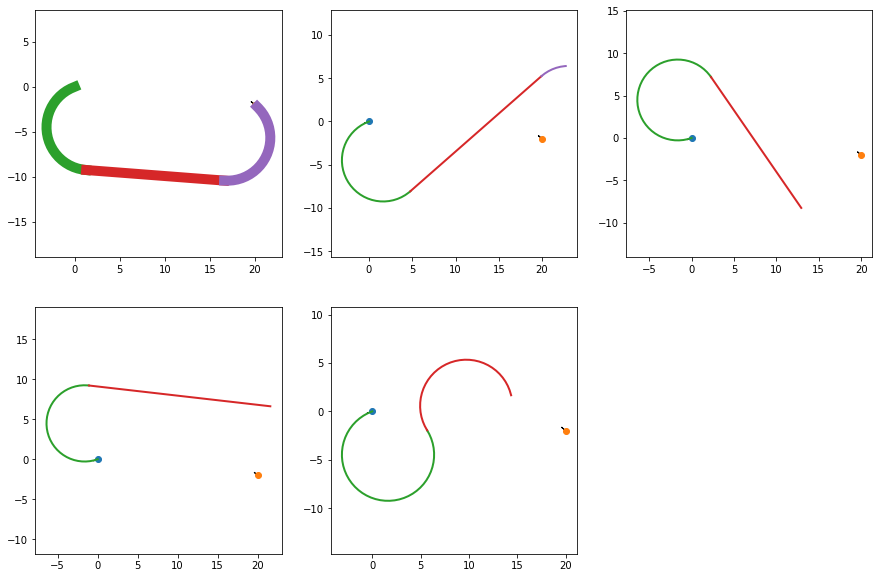

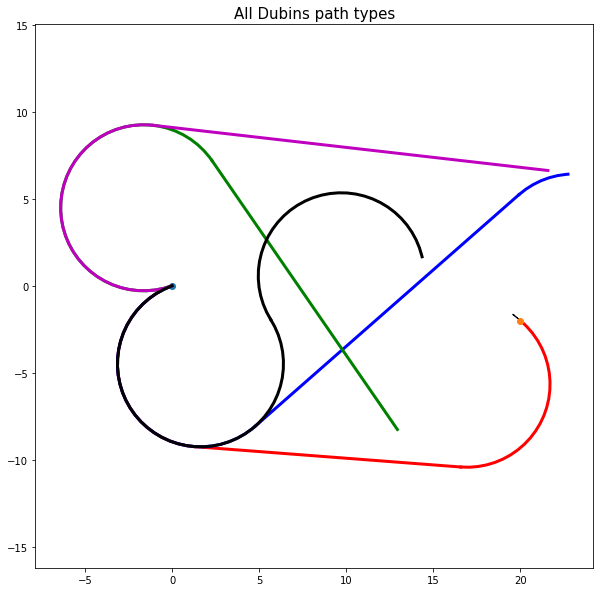

In [164]:
def test():
    plt.figure(figsize=(15,10))
    init_state = [0,0,200 * (np.pi/180)]
    goal_state = [20,-2,140 * (np.pi/180)]
    x_list, y_list = [], []
    dubins = DubinsPath(init_state, goal_state, r_turn)
    dubins.set_dubins_path(step_size=X_EXPAND)
    shortest_path, _ = dubins.get_shortest_path()
#     print(shortest_path)

    for i in range(len(dubins.dubins_words)):
        path = dubins.path[i]
        color = "k"
        linewidth = 2
        if path == shortest_path:
            color = "r"
            linewidth = 10
#         print("Dubins path : ", path)
        if path:
            plt.subplot(2,3,i+1)
            len_path = len(path)
                      
#             plt.title('{}{}{}'.format(path[0][0], path[1][0], path[2][0]), fontsize=20, color=color)
            dubins.draw_point(init_state)
            dubins.draw_point(goal_state)
            xs, ys, thetas = DubinsPath.gen_dubins_path(init_state, path, r_turn)

#             print("!!! Dubins Path {}".format(i))
            for i in range(len_path):
                plt.plot(xs[i], ys[i], linewidth=linewidth)
            plt.axis('equal')

            x_list.append(xs)
            y_list.append(ys)
        
    color_set = ['r', 'b', 'g', 'm', 'k', 'c']
    plt.figure(figsize=(10,10))
    dubins.draw_point(init_state)
    dubins.draw_point(goal_state)
    plt.title("All Dubins path types", fontsize=15)
    plt.axis('equal')
    
    k = 0
    for i in range(len(dubins.dubins_words)):
        path = dubins.path[i]
        if path:
            len_path = len(path)
            for j in range(len_path):
                plt.plot(x_list[k][j], y_list[k][j], color_set[k], linewidth=3)
            k += 1
        
if __name__ == "__main__":
    test()
    

In [162]:
2*r_turn * np.pi

29.952034651065706